In [211]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from tqdm import tqdm
import pdb
import copy

import sys
import os

#########################
# Experiment parameters #
#########################
from sklearn.base import clone
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sys.path.append('../third_party')
sys.path.append('../methods')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data generation

In [212]:
from models import GaussianMixture, ConcentricCircles, ConcentricCircles2, ConcentricCirclesMixture, BinomialModel

random_state = 2022

model_name = "circles-mix"

if model_name == "GaussianMixture":
    p = 20        # Number of features
    a = 0.25         # Signal amplitude
    model = GaussianMixture(p, a, random_state=random_state)
    purity = 0.8    # Proportion of inliers
    n = 1000          # Number of observations
    
elif model_name == "circles-mix":
    p = 1000        # Number of features
    a = 0.5        # Signal amplitude
    model = ConcentricCirclesMixture(p, a, random_state=random_state)
    purity = 0.5      # Proportion of inliers
    n = 500          # Number of observations

elif model_name == "circles":
    p = 1000        # Number of features
    a = 0.99        # Signal amplitude
    model = ConcentricCircles(p, a, random_state=random_state)
    purity = 0.9      # Proportion of inliers
    n = 1000          # Number of observations
    
elif model_name == "BinomialModel":
    p = 100        # Number of features
    a = 3          # Signal amplitude
    model = BinomialModel(p, a, random_state=random_state)
    purity = 0.9     # Proportion of inliers
    n = 1000          # Number of observations
    
else:
    print("Error: unknown model name!")
    
    
n_test = 2000     # Number of test points
purity_test = 0.5 # Proportion of inliers in test set

X, Y = model.sample(n, purity)
X_test, Y_test = model.sample(n_test, purity)

print("Number of inliers in training/calibration data: {}.".format(np.sum(Y==0)))
print("Number of outliers in training/calibration data: {}.".format(np.sum(Y==1)))

print("Number of inliers in test data: {}.".format(np.sum(Y_test==0)))
print("Number of outliers in test data: {}.".format(np.sum(Y_test==1)))

Number of inliers in training/calibration data: 250.
Number of outliers in training/calibration data: 250.
Number of inliers in test data: 1000.
Number of outliers in test data: 1000.


## Conformal p-values via one-class classification

In [213]:
# Define list of possible one-class classifiers with desired hyper-parameters
bbox_occ_list = [svm.OneClassSVM(kernel='rbf', degree=3),
                 svm.OneClassSVM(kernel='sigmoid', degree=3),
                 svm.OneClassSVM(kernel='poly', degree=3),
                 IsolationForest(contamination = 'auto', random_state=random_state),
                 LocalOutlierFactor(contamination='auto', novelty=True)
               ]

# Choose a one-class classifier algorithm
bbox_occ = bbox_occ_list[0]

Fitting the black-box model on 125 data points... done.
Calculating conformity scores for 125 hold-out data points... done.
Calculating conformity scores for 2000 test points... done.


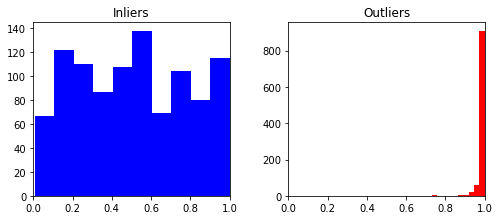

In [214]:
from methods_split import OneClassConformal

# Extract the inliers from the data
X_in = X[Y==0]

# Compute the p-values
method_oneclass = OneClassConformal(X_in, bbox_occ, calib_size=0.5)
pvals_oneclass = method_oneclass.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_oneclass[Y_test==0], color="blue")
axs[1].hist(pvals_oneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Conformal p-values via weighted one-class classification

Fitting a one-class classification model on 125 data points... done.
Fitting a one-class classification model on 125 data points... done.


100%|██████████| 2000/2000 [00:01<00:00, 1414.76it/s]


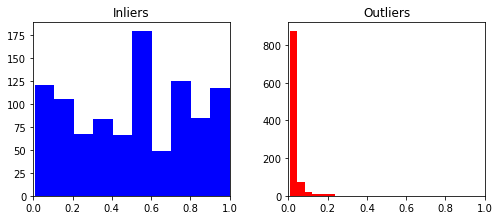

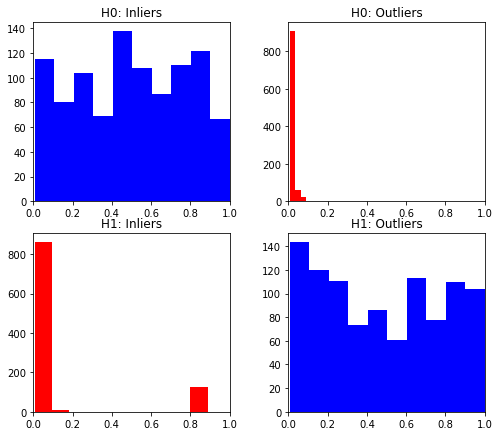

0.019698412698412694

In [218]:
from methods_split import WeightedOneClassConformal
from sklearn.linear_model import SGDOneClassSVM

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one_in = [svm.OneClassSVM(kernel='rbf')
               ]
bboxes_one_out = [svm.OneClassSVM(kernel='rbf', gamma=0.001)
                ] 

# Compute the p-values
method_woc = WeightedOneClassConformal(X_in, X_out, bboxes_one=bboxes_one_in, bboxes_one_out=bboxes_one_out,
                                       calib_size=0.5, tuning=True)
pvals_woneclass, pvals_woneclass_0, pvals_woneclass_1 = method_woc.compute_pvalues(X_test, return_prepvals=True)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_woneclass[Y_test==0], color="blue")
axs[1].hist(pvals_woneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Plot the preliminary p-values
fig, axs = plt.subplots(2,2, figsize=(7,6))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0,0].hist(pvals_woneclass_0[Y_test==0], color="blue")
axs[0,1].hist(pvals_woneclass_0[Y_test==1], color="red")  
axs[1,0].hist(pvals_woneclass_1[Y_test==0], color="red")
axs[1,1].hist(pvals_woneclass_1[Y_test==1], color="blue")  
axs[0,0].title.set_text('H0: Inliers')
axs[0,1].title.set_text('H0: Outliers')
axs[1,0].title.set_text('H1: Inliers')
axs[1,1].title.set_text('H1: Outliers')
axs[0,0].set_xlim(0,1)
axs[0,1].set_xlim(0,1)
axs[1,0].set_xlim(0,1)
axs[1,1].set_xlim(0,1)
plt.show()

np.mean(pvals_woneclass[Y_test==1])

In [219]:
# Expected value of U1 under Y=0
E_u1_Y0 = np.mean(pvals_woneclass_1[Y_test==0])

n1 = int(0.5*X_out.shape[0])
RHS = 1/np.log(n1+1)

print("E_u1_Y0 = {:.3f}; RHS {:.3f}".format(E_u1_Y0, RHS))

E_u1_Y0 = 0.121; RHS 0.207


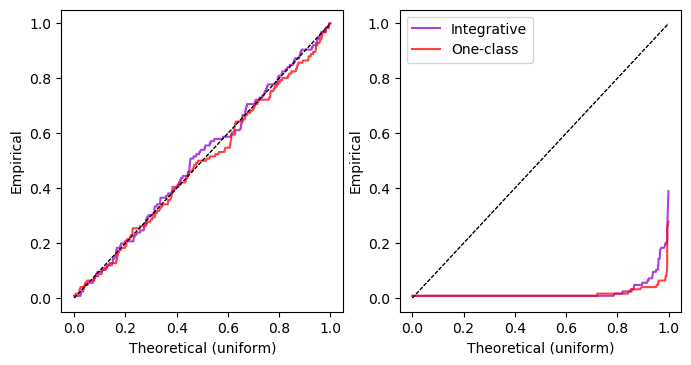

In [220]:
def qq_plot(data, reference, ax, color=None, label=None, logarithm=False):
    sample_size = len(data)
    qq = np.ones([sample_size, 2])
    np.random.shuffle(data)
    qq[:, 0] = np.sort(reference)
    qq[:, 1] = np.sort(data[0:sample_size])
    if color is None:
        ax.plot(qq[:,0], qq[:,1], label=label, alpha=0.75)
    else:
        ax.plot(qq[:,0], qq[:,1], color=color, label=label, alpha=0.75)
    ax.plot([0,1], [0,1], color="black", linewidth=0.75, linestyle="dashed")
    ax.set_xlabel("Theoretical (uniform)")
    ax.set_ylabel("Empirical")
    if logarithm:
        ax.set_xscale('log')
        ax.set_yscale('log')        
        
fig, axs = plt.subplots(1,2, figsize=(8,4), dpi= 100)

logarithm = False
U = np.random.uniform(size = (len(Y_test),))
for y in [0,1]:
    qq_plot(pvals_woneclass[Y_test==y], U[Y_test==y], axs[y], label="Integrative", color='#9400d3',
            logarithm=logarithm)
    qq_plot(pvals_woneclass_0[Y_test==y], U[Y_test==y], axs[y], label="One-class", color='red',
            logarithm=logarithm)

plt.legend()
plt.show()